In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import readdy

## Setup ReaDDy system

In [2]:
system = readdy.ReactionDiffusionSystem([20.,20.,20.], temperature=300.*readdy.units.kelvin)

system.add_species("A", diffusion_constant=1.0)
system.add_species("B", diffusion_constant=1.0)
system.add_species("C", diffusion_constant=1.0)

lambda_on = 1.
system.reactions.add("myfusion: A +(1) B -> C", rate=lambda_on/readdy.units.nanosecond)

## Simulate the system

In [3]:
simulation = system.simulation(kernel="CPU")
simulation.output_file = "out.h5"
simulation.reaction_handler = "Gillespie"

n_particles = 2000
initial_positions_a = np.random.random(size=(n_particles, 3)) * 20. - 10.
initial_positions_b = np.random.random(size=(n_particles, 3)) * 20. - 10.
simulation.add_particles("A", initial_positions_a)
simulation.add_particles("B", initial_positions_b)

simulation.observe.number_of_particles(stride=1, types=["A"])

In [4]:
if os.path.exists(simulation.output_file):
    os.remove(simulation.output_file)

simulation.run(n_steps=5000, timestep=1e-3*readdy.units.nanosecond)

Box(children=(Text(value=''), IntProgress(value=0)))

In [5]:
traj = readdy.Trajectory(simulation.output_file)
time, counts = traj.read_observable_number_of_particles()

## Analytic solution
In ReaDDy, one defines the intrinsic rate constant. In a well-mixed setting, one can use the following
equation (see [1]) to obtain the corresponding macroscopic rate (ODE rate equation/ law of mass action)

$$
k_\mathrm{on} = 4\pi (D_A + D_B) R \left[1 - \frac{\tanh(\kappa R)}{\kappa R}\right]
$$

where

$$
\kappa = \sqrt{\frac{\lambda_\mathrm{on}}{D_A + D_B}}
$$

Parameters:
- intrinsic rate constant $\lambda_\mathrm{on} = 1\,\mathrm{ns}^{-1}$
- diffusion coefficient $D_A=D_B=1\, \mathrm{nm}^2 \mathrm{ns}^{-1}$
- reaction radius $R = 1\,\mathrm{nm}$

Law of mass action ODE for the concentration of A particles $[A](t) = a(t)$

$$
\frac{\mathrm{d}a}{\mathrm{d}t} = -k_\mathrm{on}\,a^2 \quad\text{, with } a(0) = a_0
$$

which yields

$$
a(t) = \frac{1}{a_0^{-1} + k_\mathrm{on}t}
$$

[1]: R. Erban and J. Chapman, “Stochastic modelling of reaction-diffusion processes: algorithms for bimolecular reactions.,” Phys. Biol., vol. 6, no. 4, p. 46001, Jan. 2009.

In [6]:
kappa = np.sqrt(lambda_on / 2.)
k_on = 4. * np.pi * 2. * 1. * (1. - np.tanh(kappa * 1.) / (kappa * 1.) )

def a(t): 
    return 1. / ((system.box_volume.magnitude / n_particles) + k_on * t)

t_range = np.linspace(0., 5000 * 1e-3, 10000)

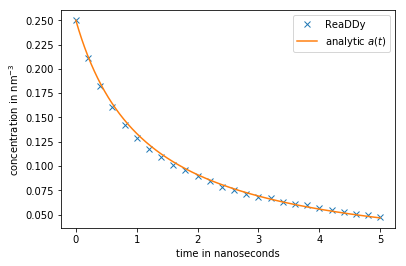

In [7]:
plt.plot(time[::200]*1e-3, counts[::200] / system.box_volume.magnitude, "x", label="ReaDDy")
plt.plot(t_range, a(t_range), label=r"analytic $a(t)$")
plt.legend(loc="best")
plt.xlabel("time in nanoseconds")
plt.ylabel(r"concentration in nm$^{-3}$")
plt.show()

Note that in the diffusion-limited regime, the law of mass action solution generally does not reflect what can be observed from the Doi model.